In [1]:
import pandas as pd
from Skeleton import Skeleton,DynamicSkeleton
import nimblephysics as nimble
import numpy as np
import json
import time

s12 = Skeleton('/home/rmhri/markerless-human-perception/src/hpe/src/Biomechanical-Model/BODY12.xml')
# Rajagopal
# s = DynamicSkeleton('/home/rmhri/markerless-human-perception/src/hpe/src/Biomechanical-Model/BODY15_constrained_3D.xml')
# BSM
s = DynamicSkeleton(config='/home/rmhri/markerless-human-perception/src/hpe/src/Biomechanical-Model/BODY15_constrained_3D.xml', \
    osim_file='/media/rmhri/mrom/data/skel_models_v1.1/bsm.osim',\
    max_velocity=2)# \
    # geometry_dir='/home/rmhri/markerless-human-perception/src/hpe/src/Biomechanical-Model/data/skel_models_v1.1/Geometry/')

kps =  ['RKnee', 'LWrist', 'RHip', 'RShoulder',  'LElbow', 'LHip', 'RElbow', 'RWrist', 'LKnee', 'LShoulder', 'RAnkle', 'LAnkle']
gui = nimble.NimbleGUI()
gui.serve(8080)
# gui.nativeAPI().renderBasis()
# sudo lsof -iTCP:8080 -sTCP:LISTEN
with open('tmp/camera-parameters.json') as f:
    parameters = json.load(f)

R = np.array(parameters["extrinsics"]['S9']['60457274']['R'])
T = np.array(parameters["extrinsics"]['S9']['60457274']['t'])
RT = np.vstack([np.hstack([R,T]),np.array([0,0,0,1])])
RT = np.linalg.inv(RT)
R = RT[0:3,0:3]
T = RT[0:3,3].reshape(3,1)

# gui.nativeAPI().renderSkeleton(s._nimble)

# [s._nimble.getJoint(i).getDofName(j) for i in range(s._nimble.getNumJoints()) for j in range(s._nimble.getJoint(i).getNumDofs())]
# j = s._nimble.getJoint(2)

# j.getNumDofs?

Setting len to 0.1
Setting neutral pos to   0
0.7
  0
Setting len to 0.3
Setting neutral pos to    0
-0.6
   0
Setting len to 0.1
Setting neutral pos to   0
0.2
  0
GUIWebsocketServer will start serving a WebSocket server on ws://localhost:8070
Web GUI serving on http://localhost:8080


In [2]:
# gui.nativeAPI().renderSkeleton(s15.nimble_skeleton)
action = "Directions"
error = "trtfcn"
notes = "_confidence"

df = pd.read_csv('/home/rmhri/mrom/data/S9_' + action + '.60457274_' + error + '.csv')
# df = pd.read_csv('/home/rmhri/mrom/data/S9_Walking.60457274_gt.csv')
# Directions Walking SittingDown
t = 0
Q = []
P = []
P_target = []
times = []
s.prob = None
s.reset()
to_delete = np.random.randint(low=0,high=12,size=6)
for t in range(0,df.shape[0]):
    target = np.array([np.array(df.loc[t,[l+":X",l+":Y",l+":Z"]].to_numpy()) for l in kps]).squeeze()/1000
    
    # Rotate for beautiful view
    res = np.dot(R,target.reshape(-1,3).transpose()*1000) + T
    Rx = np.array([
        [1,0,0],
        [0,0,1],
        [0,-1,0]
    ])
    res = np.dot(Rx,res)
    target = res.transpose()/1000
    
    # Remove a keypoint
    # if t % 10 == 0:    
    #     to_delete = np.random.randint(low=0,high=12,size=6)
    # target[to_delete,:] = np.nan
    # target[2,:] = np.nan
    
    s12.load_from_numpy(target.reshape(-1,3),kps)
    s.load_from_BODY12(s12)
    # s.estimate_confidence()
    s.scale()
    
    # s.gdIK(1000)
    start = time.time()
    # s.qpIK(100,0.02,precision=0.0001)
    s.filter(dt=0.02)    
    stop = time.time()
    
    times.append(stop-start)
    # break
    
    # Rendering
    gui.nativeAPI().renderSkeleton(s._nimble)
        
    # Plot the measurement
    target = target.reshape(-1,1)
    for i in range(0,int(target.shape[0]/3)):
        gui.nativeAPI().createSphere(key=kps[i], radii=np.array([0.01,0.01,0.01]),pos=target[3*i:3*i+3],color=np.array([0,255,0,0.8]))

    pos = s._nimble.getJointWorldPositions(s.joints)
    pos = s.correct(pos)

    for i in range(0,int(pos.shape[0]/3)):
        gui.nativeAPI().createSphere(key=s.joints[i].getName(), radii=np.array([0.01,0.01,0.01]),pos=pos[3*i:3*i+3],color=np.array([0,0,0,1]))
    Q.append(s._nimble.getPositions())
    P.append(s.to_numpy())
    P_target.append(target)
    time.sleep(0.005)
    gui.nativeAPI().createSphere(key="COM", radii=np.array([0.01,0.01,0.01]),pos=s._nimble.getCOM(),color=np.array([1,0,0,1]))
    # gui.nativeAPI().createBox(key="ground",size=np.array([10,0,10]),color=np.array([0.5,0.5,0.5,0.4]))
    # break
    # print(t,np.round(s._nimble.getBodyScales().reshape(-1,3)[:,0].transpose(),2))
Q = np.array(Q)
P = np.array(P)
P_target = np.array(P_target)
print(np.mean(times))

127.0.0.1 - - [24/Apr/2024 19:11:39] "GET / HTTP/1.1" 304 -


0.017669586925075514


In [3]:
# Debug
notes = "_kf05"
print(np.mean(times))
np.savetxt("tmp/Q_" + action + "_" + error + notes + ".csv",Q,delimiter=',')
np.savetxt("tmp/P_" + action + "_" + error + notes + ".csv",P,delimiter=',')
np.savetxt("tmp/P_" + action + "_" + error + "_target.csv",P_target.squeeze(),delimiter=',')

0.017669586925075514


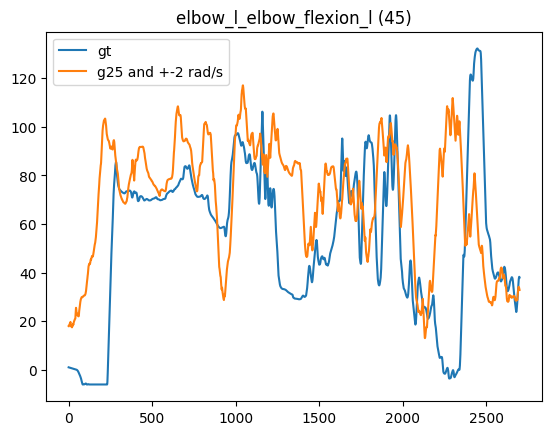

In [4]:
import numpy as np

# notes = "_2rads"

Q_gt = np.loadtxt("tmp/Q_"+ action +"_gt.csv", delimiter=',')
Q_qp2r = np.loadtxt("tmp/Q_"+ action +"_"+ error + notes +".csv", delimiter=',')
# Q_qp10r = np.loadtxt("tmp/Q_"+ action +"_"+ error +"_10rads.csv", delimiter=',')

import matplotlib.pyplot as plt
angles = []
for i in range(s._nimble.getNumJoints()):
    j = s._nimble.getJoint(i)
    for k in range(j.getNumDofs()):
        angles.append(j.getName()+'_'+j.getDofName(k))

i = 45
plt.title(angles[i]+" ("+str(i)+")" )
plt.plot(np.array(Q_gt)[:,i]*180/np.pi,label="gt")
# plt.plot(np.array(Q_qp10r)[:,i]*180/np.pi,label="g25 and +-10 rad/s")
plt.plot(np.array(Q_qp2r)[:,i]*180/np.pi,label="g25 and +-2 rad/s")
plt.legend()
plt.show()

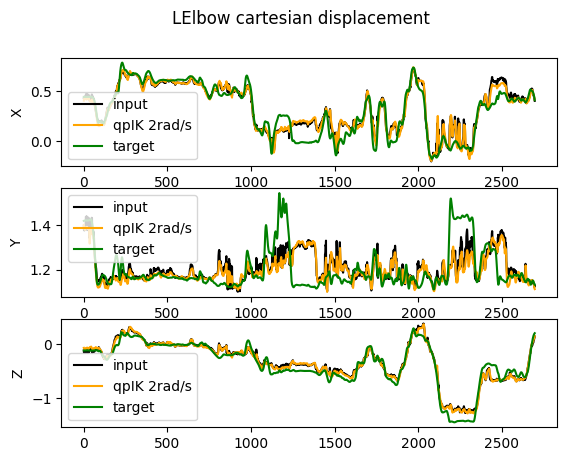

In [5]:
import numpy as np

# notes = "_confidence"

P_gt_target =    np.loadtxt("tmp/P_"+ action +"_gt_target.csv", delimiter=',')
P_g25_target = np.loadtxt("tmp/P_"+ action +"_"+ error +"_target.csv", delimiter=',')
P_gt =    np.loadtxt("tmp/P_"+ action +"_gt.csv", delimiter=',')
P_qp2r =  np.loadtxt("tmp/P_"+ action +"_"+ error +notes+".csv", delimiter=',')
# P_qp10r = np.loadtxt("tmp/P_"+ action +"_"+ error +"_10rads.csv", delimiter=',')

fig, axs = plt.subplots(3,1)

kp = "LElbow"


plt.suptitle(kp+" cartesian displacement")
axs[0].plot(np.array(P_g25_target)[:,3*kps.index(kp)],label="input",color="black")
axs[0].plot(np.array(P_qp2r)[:,3*kps.index(kp)],label="qpIK 2rad/s",color="orange")
axs[0].plot(np.array(P_gt_target)[:,3*kps.index(kp)],label="target",color="green")
axs[0].legend()
axs[0].set_ylabel("X")

axs[1].plot(np.array(P_g25_target)[:,3*kps.index(kp)+1],label="input",color="black")
axs[1].plot(np.array(P_qp2r)[:,3*kps.index(kp)+1],label="qpIK 2rad/s",color="orange")
axs[1].plot(np.array(P_gt_target)[:,3*kps.index(kp)+1],label="target",color="green")
axs[1].legend()
axs[1].set_ylabel("Y")

axs[2].plot(np.array(P_g25_target)[:,3*kps.index(kp)+2],label="input",color="black")
axs[2].plot(np.array(P_qp2r)[:,3*kps.index(kp)+2],label="qpIK 2rad/s",color="orange")
axs[2].plot(np.array(P_gt_target)[:,3*kps.index(kp)+2],label="target",color="green")
axs[2].legend()
axs[2].set_ylabel("Z")
plt.show()

In [ ]:
# Quantitative analysis on Human3.6M dataset


In [ ]:
import pandas as pd
from Skeleton import Skeleton,DynamicSkeleton
import nimblephysics as nimble
import numpy as np
import json
import time
kps =  ['RKnee', 'LWrist', 'RHip', 'RShoulder',  'LElbow', 'LHip', 'RElbow', 'RWrist', 'LKnee', 'LShoulder', 'RAnkle', 'LAnkle']
s12 = Skeleton('/home/rmhri/markerless-human-perception/src/hpe/src/Biomechanical-Model/BODY12.xml')
s = DynamicSkeleton(config='/home/rmhri/markerless-human-perception/src/hpe/src/Biomechanical-Model/BODY15_constrained_3D.xml', \
    osim_file='/media/rmhri/mrom/data/skel_models_v1.1/bsm.osim')
# Debug qpIK
df = pd.read_csv('/home/rmhri/mrom/data/S9_Directions.60457274_gt.csv')
t = 0
Q = []
P = []
print("Starting qpIK:\n")
total_time = 0
for t in range(df.shape[0]):
    target = np.array([np.array(df.loc[t,[l+":X",l+":Y",l+":Z"]].to_numpy()) for l in kps]).squeeze()/1000
        
    s12.load_from_numpy(target.reshape(-1,3),kps)
    s.load_from_BODY12(s12)
    s.scale()
    begin = time.time()
    # s.qpIK(100)
    print(t)
    if t == 0:
        s.qpIK(100)
    else:
        s.qpIK(100,0.02)
    total_time += time.time()-begin
    
    Q.append(s._nimble.getPositions())
    P.append(s.to_numpy())

print(total_time/df.shape[0])
    
Q = np.array(Q)
P = np.array(P)



In [ ]:
# Decomposing nimble forward kinematics
pos = s._nimble.getJointWorldPositions(s.joints)

# s._nimble.getPositions()

J = s._nimble.getJoint(1)
# print(pos[0:3])

transform = J.getParentBodyNode()
# transform.
print(transform.rotation(),transform.translation())
# trans = transform.translate()

In [ ]:
import matplotlib.pyplot as plt


angles = []
for i in range(s._nimble.getNumJoints()):
    j = s._nimble.getJoint(i)
    for k in range(j.getNumDofs()):
        angles.append(j.getName()+'_'+j.getDofName(k))
    
i = 20
    
plt.plot(np.array(Q)[:,i],label=angles[i])
plt.legend()
plt.show()


In [ ]:
from Skeleton import Skeleton,DynamicSkeleton
import numpy as np
s = DynamicSkeleton(config='/home/rmhri/markerless-human-perception/src/hpe/src/Biomechanical-Model/BODY15_constrained_3D.xml', \
    osim_file='/home/rmhri/markerless-human-perception/src/hpe/src/Biomechanical-Model/data/skel_models_v1.1/bsm.osim')

RCAJ = np.array([0.015,-0.035,-0.02])
RHGT = np.array([-0.05,0,0])
LCAJ = np.array([0.015,-0.035,0.02])
LHGT = np.array([-0.05,0,0])


scapula = s._nimble.getBodyNode('scapula_l')
transform = scapula.getWorldTransform()
gui.nativeAPI().renderSkeleton(s._nimble)
gui.nativeAPI().createSphere(key="LCAJ", radii=np.array([0.005,0.005,0.005]),pos=transform.multiply(LCAJ),color=np.array([255,0,0,1]))
gui.nativeAPI().createSphere(key="LHGT", radii=np.array([0.005,0.005,0.005]),pos=transform.multiply(LHGT),color=np.array([255,0,0,1]))
scapula = s._nimble.getBodyNode('scapula_r')
transform = scapula.getWorldTransform()
gui.nativeAPI().createSphere(key="RCAJ", radii=np.array([0.005,0.005,0.005]),pos=transform.multiply(RCAJ),color=np.array([255,0,0,1]))
gui.nativeAPI().createSphere(key="RHGT", radii=np.array([0.005,0.005,0.005]),pos=transform.multiply(RHGT),color=np.array([255,0,0,1]))